<h2 style="text-align:center;">Bank_Marketing_Subscription_Model</h2>

  Input variables:
   ##### bank client data:
   1 - age (numeric)</br>
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") </br>
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)</br>
   4 - education (categorical: "unknown","secondary","primary","tertiary") </br>
   5 - default: has credit in default? (binary: "yes","no") </br>
   6 - balance: average yearly balance, in euros (numeric) </br>
   7 - housing: has housing loan? (binary: "yes","no")</br>
   8 - loan: has personal loan? (binary: "yes","no")</br>
   ###### related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") </br>
  10 - day: last contact day of the month (numeric)</br>
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")</br>
  12 - duration: last contact duration, in seconds (numeric)</br>
   ###### other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)</br>
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)</br>
  15 - previous: number of contacts performed before this campaign and for this client (numeric)</br>
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")</br>

   ###### Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [26]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#----regular expressions----
import re

#----model and support imports----
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# Feature Engineering
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# Deployment
from flask import Flask, render_template, request
import pickle

# Set the default style for plotting
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading dataset
data = pd.read_csv('data/bank/bank-full.csv', delimiter=';')

# Display the first few rows of the dataset to get an overview
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
# Display basic statistics of the dataset
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
data.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


In [6]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [7]:
#Looking for duplicated values
data.duplicated().sum()

0

In [8]:
columns = data.columns
print("----------- Numeric field ----------\n")
for i in range(len(columns)):
    if data[columns[i]].dtypes!=object:
        print("unique number of {} ---> {}".format(columns[i], len(data[columns[i]].unique())))
        
print("\n---------- Categorical field ----------\n")
for i in range(len(columns)):
    if data[columns[i]].dtypes==object:
        print("unique number of {} ---> {}".format(columns[i], len(data[columns[i]].unique())))

----------- Numeric field ----------

unique number of age ---> 77
unique number of balance ---> 7168
unique number of day ---> 31
unique number of duration ---> 1573
unique number of campaign ---> 48
unique number of pdays ---> 559
unique number of previous ---> 41

---------- Categorical field ----------

unique number of job ---> 12
unique number of marital ---> 3
unique number of education ---> 4
unique number of default ---> 2
unique number of housing ---> 2
unique number of loan ---> 2
unique number of contact ---> 3
unique number of month ---> 12
unique number of poutcome ---> 4
unique number of y ---> 2


#### Data Visualization

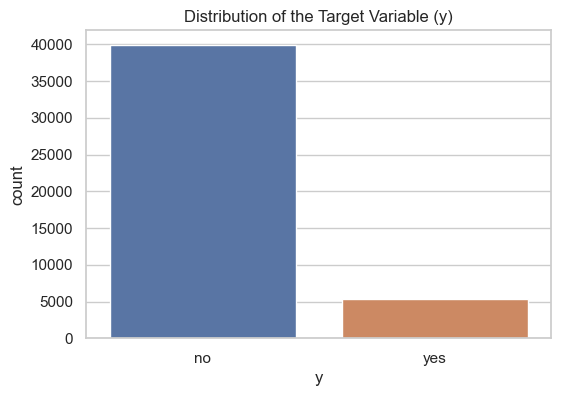

In [9]:
# Visualize the distribution of the target variable 'y'
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=data)
plt.title('Distribution of the Target Variable (y)')
plt.show()

As we can see our dataset is highly imbalanced. This means, if we move forward with the same dataset without making any changes, we will have a model which predicts every output towards the majority of result, means towards No. 

So We need to do Oversampling and we will be using SMOTE(Synthetic Minority Over-sampling Technique). SMOTE generates synthetic samples for the minority class, which helps in balancing the class distribution.

#### Data Preprocessing

One-hot encoding: Converting each categorical variable into a set of binary columns, where each column represents a unique category. This will allow us to include these variables in our machine learning model.

In [10]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'], drop_first=True)

# Display the first few rows of the encoded data
data_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,no,False,False,...,False,False,False,True,False,False,False,False,False,True
1,44,29,5,151,1,-1,0,no,False,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,5,76,1,-1,0,no,False,True,...,False,False,False,True,False,False,False,False,False,True
3,47,1506,5,92,1,-1,0,no,True,False,...,False,False,False,True,False,False,False,False,False,True
4,33,1,5,198,1,-1,0,no,False,False,...,False,False,False,True,False,False,False,False,False,True


#### Model configuration

We will use XGBoost and then use TensorFlow to see if we get better performance using a Neural Network. <br>
We will use SMOTE (synthetic minority oversampling technique) to correct for imbalance while using TensorFlow.

We will use XGBoost and then use TensorFlow to see if we get better performance using a Neural Network. <br>
We will use SMOTE (synthetic minority oversampling technique) to correct for imbalance while using TensorFlow.

<Axes: >

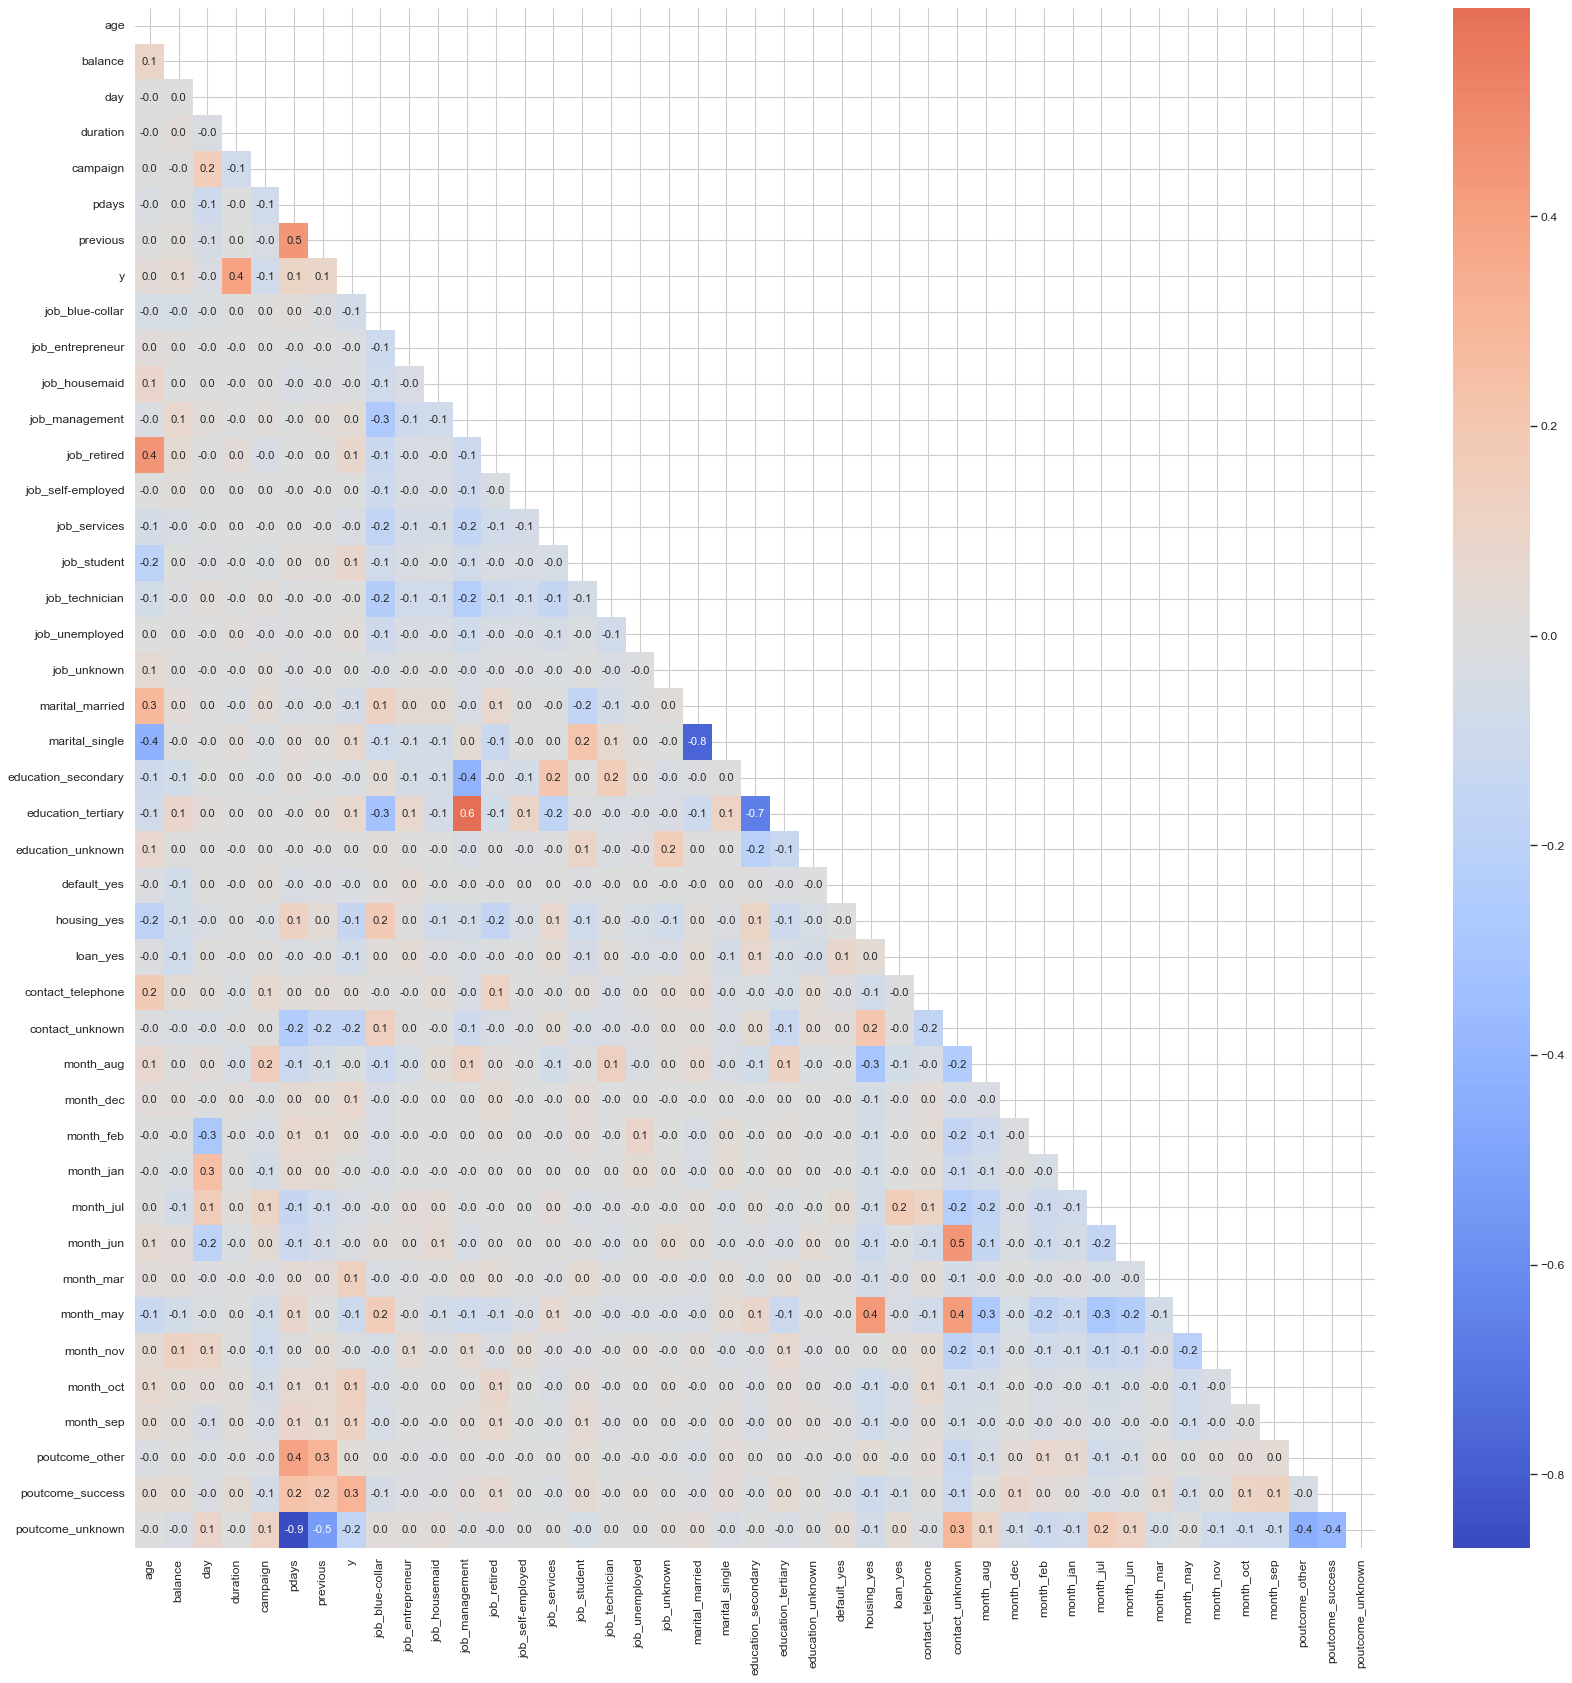

In [31]:
matrix = np.triu(np.ones_like(data_encoded.corr()))
fig, ax = plt.subplots(figsize=(25,25),dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(data_encoded.corr(), mask= matrix, cmap="coolwarm", annot = True, fmt = '.1f', center = 0,annot_kws={"fontsize":10})

Now that we've one-hot encoded the categorical variables, the next step is to split the data into features (X) and the target variable (y) and perform the train-test split. We'll also standardize the numeric features.

In [11]:
# Separate features (X) and target variable (y)
X = data_encoded.drop('y', axis=1)
y = data_encoded['y']

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Standardize the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Display the shapes of the training and testing sets
(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

((36168, 42), (9043, 42), (36168,), (9043,))

Now, let's move on to the oversampling step using SMOTE. After that, we can explore the data to ensure it's balanced and then proceed with building and evaluating the machine learning model.

In [15]:
# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [16]:
# Display the shapes of the resampled training data
(X_train_resampled.shape, y_train_resampled.shape)

((63874, 42), (63874,))

In [17]:
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the resampled training data
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          no       0.95      0.94      0.94      7985
         yes       0.56      0.59      0.58      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.76      0.76      9043
weighted avg       0.90      0.90      0.90      9043


Accuracy Score: 0.898595598805706


The Random Forest Classifier seems to be performing reasonably well with a good accuracy score. Now, proceed with hyperparameter tuning to see if we can further improve the model's performance.

We can use tools like GridSearchCV or RandomizedSearchCV for hyperparameter tuning.

Using RandomizedSearchCV since the dataset is large and takes long computational time during GridSearchCV.

Since XGBoost is expecting binary classes represented as integers (0 and 1), we need to convert 'no' and 'yes' to 0 and 1

In [24]:
# Convert 'no' and 'yes' to 0 and 1
y_train_binary = y_train.map({'no': 0, 'yes': 1})
y_test_binary = y_test.map({'no': 0, 'yes': 1})

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=10,
    scoring='accuracy', cv=5, random_state=42, n_jobs=-1
)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train_binary)

# Print the best parameters and their corresponding accuracy
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

Best Hyperparameters: {'colsample_bytree': 0.9754210836063001, 'gamma': 0.0007787658410143283, 'learning_rate': 0.30766346778736525, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 138, 'scale_pos_weight': 1, 'subsample': 0.8099098641033556}
Best Accuracy Score: 0.9079849900012466


It seems like the RandomizedSearchCV has found the best hyperparameters for the XGBoost model. The hyperparameters are listed, and we can use them to initialize a new XGBoost model for the final evaluation.

In [27]:
# Initialize XGBoost model with the best hyperparameters
best_xgb_model = XGBClassifier(
    colsample_bytree=0.9754210836063001,
    gamma=0.0007787658410143283,
    learning_rate=0.30766346778736525,
    max_depth=3,
    min_child_weight=6,
    n_estimators=138,
    scale_pos_weight=1,
    subsample=0.8099098641033556,
    random_state=42
)

# Fit the model to the training data
best_xgb_model.fit(X_train, y_train_binary)

# Predict on the test data
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_binary, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_binary, y_pred, average='binary')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9069998894172288
Precision: 0.6464237516869096
Recall: 0.45274102079395084
F1 Score: 0.5325180655919955


Accuracy: The ratio of correctly predicted instances to the total instances. In this case, it's around 90.7%, indicating a good overall accuracy.

Precision: The ability of the classifier not to label as positive a sample that is negative. In this case, it's around 64.6%. It suggests that when the model predicts a positive outcome, it's correct about 64.6% of the time.

Recall (Sensitivity): The ability of the classifier to find all the positive samples. In this case, it's around 45.3%. It indicates that the model captures about 45.3% of the actual positive instances.

F1 Score: The weighted average of precision and recall. It balances precision and recall. In this case, it's around 53.2%.

Considering these metrics, our model seems to have good accuracy, but the precision and recall are moderate.

##### Feature Importance Analysis

In [33]:
# Since XGBoost model is named 'best_xgb_model'
feature_importance = best_xgb_model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance_df.head())

             Feature  Importance
40  poutcome_success    0.293516
34         month_mar    0.073956
3           duration    0.069348
27   contact_unknown    0.056869
24       housing_yes    0.045303


##### Findings:

poutcome_success (0.293516): This feature seems to be the most important according to your XGBoost model. It suggests that a successful outcome from a previous marketing campaign significantly influences the likelihood of a customer subscribing.

month_mar (0.073956): The month of March appears to have a noteworthy impact. It could indicate a seasonality effect, where marketing efforts in March are particularly effective.

duration (0.069348): The duration of the last contact also holds substantial importance. This aligns with common intuition – longer conversations might imply deeper engagement, potentially leading to a higher chance of subscription.

contact_unknown (0.056869): Customers with an unknown contact method contribute significantly to the model's predictions. This could highlight a need for improving data collection or outreach strategies for customers with unknown contact information.

housing_yes (0.045303): The fact that a customer has a housing loan (yes) is also a relevant feature. This suggests that housing status influences the subscription decision.

#### Testing with Other Models

##### Random Forest

In [35]:
'''# Importing the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

# Creating the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Training the model
random_forest_model.fit(X_train, y_train_binary)

# Predicting on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluating the model
accuracy_rf = accuracy_score(y_test_binary, y_pred_rf)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test_binary, y_pred_rf, average='binary')

# Displaying the results
print("Random Forest Model:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)'''

Random Forest Model:
Accuracy: 0.9048988167643481
Precision: 0.65814696485623
Recall: 0.389413988657845
F1 Score: 0.48931116389548684


##### Logistic Regression

In [36]:
'''# Importing the Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Creating the Logistic Regression model
logistic_regression_model = LogisticRegression(random_state=42)

# Training the model
logistic_regression_model.fit(X_train, y_train_binary)

# Predicting on the test set
y_pred_lr = logistic_regression_model.predict(X_test)

# Evaluating the model
accuracy_lr = accuracy_score(y_test_binary, y_pred_lr)
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_test_binary, y_pred_lr, average='binary')

# Displaying the results
print("Logistic Regression Model:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)'''

Logistic Regression Model:
Accuracy: 0.8847727524051753
Precision: 0.5239520958083832
Recall: 0.16540642722117202
F1 Score: 0.2514367816091954


Based on the different model testing, we can see XGBoost is performing the best